In [2]:
 import sys
! whoami
 print(sys.executable)
 print(sys.version)
 print(sys.version_info)
# tested on aws lightsail instance 21 July 2020 using python38 kernel spec

compthink
/opt/conda/envs/python/bin/python
3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)


# Hypothesis Testing
In this notebook we continue with hypothesis testing, but examine larger datasets but using mostly the same themes.

Also, we will reinforce the concept of accessing data files from a web server.  
The webroot for the subsequent examples/exercises is `http://atomickitty.ddns.net/documents/JupyterOrion/MyJupyterNotebooks/41A-HypothesisTests/`

## Example 1 : Do construction activities impact stormwater solids metrics?

### Background
The Clean Water Act (CWA) prohibits storm water discharge from construction sites
that disturb 5 or more acres, unless authorized by a National Pollutant Discharge
Elimination System (NPDES) permit. Permittees must provide a site description,
identify sources of contaminants that will affect storm water, identify appropriate
measures to reduce pollutants in stormwater discharges, and implement these measures.
The appropriate measures are further divided into four classes: erosion and
sediment control, stabilization practices, structural practices, and storm water management.
Collectively the site description and accompanying measures are known as
the facility’s Storm Water Pollution Prevention Plan (SW3P).
The permit contains no specific performance measures for construction activities,
but states that ”EPA anticipates that storm water management will be able to
provide for the removal of at least 80% of the total suspended solids (TSS).” The
rules also note ”TSS can be used as an indicator parameter to characterize the
control of other pollutants, including heavy metals, oxygen demanding pollutants,
and nutrients commonly found in stormwater discharges”; therefore, solids control is
critical to the success of any SW3P.
Although the NPDES permit requires SW3Ps to be in-place, it does not require
any performance measures as to the effectiveness of the controls with respect to
construction activities. The reason for the exclusion was to reduce costs associated
with monitoring storm water discharges, but unfortunately the exclusion also makes
it difficult for a permittee to assess the effectiveness of the controls implemented at
their site. Assessing the effectiveness of controls will aid the permittee concerned
with selecting the most cost effective SW3P.

### Problem Statement
The files SOLIDS.PRE.TXT and SOLIDS.DUR.TXT contain observations of cumulative
rainfall, total solids, and total suspended solids collected from a construction
site on Nasa Road 1 in Harris County. The data in the file SOLIDS.PRE.TXT was
collected `before` construction began, and the data in the file SOLIDS.DUR.TXT were
collected `during` the construction activity.

The first few lines of the `SOLIDS.PRE.TXT` file is displayed below. The first column
is the date that the observation was made, the second column the total solids (by standard methods), 
the third column is is the total suspended solids (also by standard methods), and the last column is the cumulative
rainfall for that storm.

    DATE	TS.PRE	TSS.PRE	RAIN.PRE
    03/27/97	408.5	111	1
    03/31/97	524.5	205.5	0.52
    04/04/97	171.5	249	0.95
    04/07/97	436.5	65	0.55
    04/11/97	627	510.5	2.19
    04/18/97	412.5	93	0.2
    ...

The first few lines of the `SOLIDS.DUR.TXT` file is displayed below. The first column
is the date that the observation was made, the second column is the cumulative
rainfall for that storm, the third column is the total solids (by standard methods),
and the last column is the total suspended solids (also by standard methods).

    DATE RAIN.DUR TS.DUR TSS.DUR
    7/9/1997 1.59 3014 2871.5
    7/21/1997 0.53 1137 602
    8/1/1997 0.74 2362.5 2515
    8/4/1997 0.11 395.5 130
    8/9/1997 0.27 278.5 36.5
    8/25/1997 0.69 506.5 320.5
    9/11/1997 1.06 2829.5 3071.5
    ...
Our task is to analyze these two data sets and decide if construction activities impact stormwater quality in terms of solids measures.

Some broad questions to keep in mind as we proceede:

    Which summary statistics are relevant? 
    Are the data approximately normal? 
    Are the data homoscedastic? 
    Do the two construction phases represent approximately the same rainfall conditions? 
    Assuming the observations are upstream of any water quality control feature, what amount of solids load needs to be captured to preserve pre-construction loading to the environment?
    
These data are not time series (there was sufficient time between site visits that you can safely assume each storm was independent.

The first step is to acquire the data and structure a data model - notice how the two files contain similar data, but the rainfall column is in different order, we need to deal with this probably for the beginning.

### Acquire the Data from the server

In [3]:
import requests # Module to process http/https requests
remote_webroot="http://atomickitty.ddns.net/documents/JupyterOrion/MyJupyterNotebooks/41A-HypothesisTests/"  # set the webroot
remote_url=remote_webroot+"solids.pre.txt"
rget = requests.get(remote_url, allow_redirects=True)  # get the remote resource, follow imbedded links
open('solids.pre.txt','wb').write(rget.content) # extract from the remote the contents, assign to a local file same name
remote_url=remote_webroot+"solids.dur.txt"
rget = requests.get(remote_url, allow_redirects=True)  # get the remote resource, follow imbedded links
open('solids.dur.txt','wb').write(rget.content) # extract from the remote the contents, assign to a local file same name
! ls -la # execute local bash command to show file strtucture


total 4404
drwxrwxr-x  3 compthink compthink    4096 Aug 14 20:46 .
drwxrwxr-x 32 compthink compthink    4096 Aug 14 00:35 ..
drwxrwxr-x  2 compthink compthink    4096 Aug 14 00:37 .ipynb_checkpoints
-rw-rw-r--  1 compthink compthink 1027865 Aug 14 00:33 CCBayoyMap.png
-rw-rw-r--  1 compthink compthink    2463 Aug 14 20:34 HUGHES_STREET.txt
-rw-rw-r--  1 compthink compthink   22768 Aug 14 20:21 HypothesisTests_One.ipynb
-rw-rw-r--  1 compthink compthink   64920 Aug 14 00:41 HypothesisTests_One.pdf
-rw-rw-r--  1 compthink compthink  189283 Aug 14 20:46 HypothesisTests_Two.ipynb
-rw-rw-r--  1 compthink compthink 2016339 Aug 14 00:40 HypothesisTests_Two.pdf
-rw-rw-r--  1 compthink compthink 1147711 Aug 14 00:33 SampleLocations.png
-rw-rw-r--  1 compthink compthink    1571 Aug 14 20:34 colorado.txt
-rw-rw-r--  1 compthink compthink     987 Aug 14 20:47 solids.dur.txt
-rw-rw-r--  1 compthink compthink     439 Aug 14 20:47 solids.pre.txt


Examine the files, see if we can understand their structure

<AxesSubplot:>

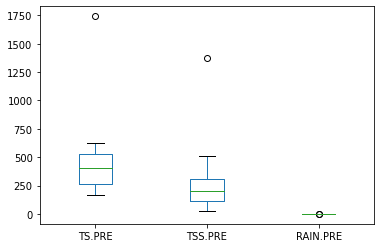

In [4]:
import pandas as pd # Module to process dataframes (not absolutely needed but somewhat easier than using primatives, and gives graphing tools)
precon = pd.read_table("solids.pre.txt") # Read the file as a table assign to a dataframe 
precon.plot.box()

<AxesSubplot:>

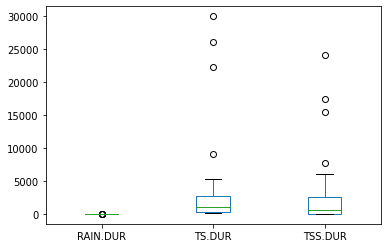

In [5]:
durcon = pd.read_table("solids.dur.txt") # Read the file as a table assign to a dataframe 
durcon.plot.box()

Here we see that the scales of the two data sets are quite different, but first lets reorder the columns so the two dataframes have the same structure.

<AxesSubplot:>

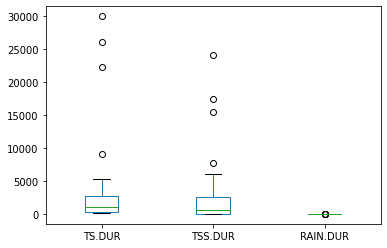

In [6]:
durcon = durcon[['TS.DUR','TSS.DUR','RAIN.DUR']] # super sneaky!
durcon.plot.box()

In [7]:
precon['RAIN.PRE'].describe()

count    17.000000
mean      0.878235
std       0.882045
min       0.130000
25%       0.460000
50%       0.690000
75%       0.950000
max       3.760000
Name: RAIN.PRE, dtype: float64

In [8]:
durcon['RAIN.DUR'].describe()

count    37.000000
mean      1.016486
std       1.391886
min       0.100000
25%       0.270000
50%       0.550000
75%       1.010000
max       6.550000
Name: RAIN.DUR, dtype: float64

If we look at the summary statistics, we might conclude there is more rainfall during construction, which could bias our interpretation, a box plot of just rainfall might be useful, as would hypothesis tests. 

<AxesSubplot:>

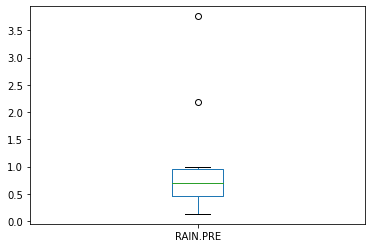

In [9]:
precon['RAIN.PRE'].plot.box()

<AxesSubplot:>

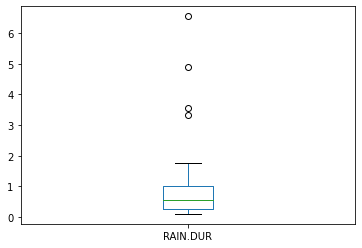

In [10]:
 durcon['RAIN.DUR'].plot.box()

Hard to tell from the plots, they look a little different, but are they?  Lets apply some hypothesis tests

In [11]:
from scipy.stats import mannwhitneyu # import a useful non-parametric test
stat, p = mannwhitneyu(precon['RAIN.PRE'],durcon['RAIN.DUR'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=291.500, p-value at rejection =0.338
Probably the same distribution


In [12]:
from scipy import stats
results = stats.ttest_ind(precon['RAIN.PRE'], durcon['RAIN.DUR'])
print('statistic=%.3f, p-value at rejection =%.3f ' % (results[0], results[1]))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=-0.375, p-value at rejection =0.709 
Probably the same distribution


From these two tests (the data are NOT paired) we conclude that the two sets of data originate from the same distribution.
Thus the question "Do the two construction phases represent approximately the same rainfall conditions?" can be safely answered in the affirmative.

Continuing, lets ask the same about total solids, first plots

<AxesSubplot:>

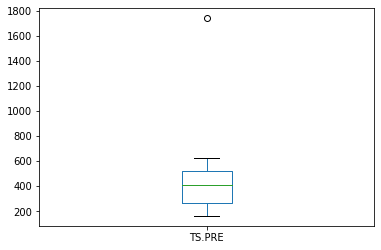

In [13]:
precon['TS.PRE'].plot.box()

<AxesSubplot:>

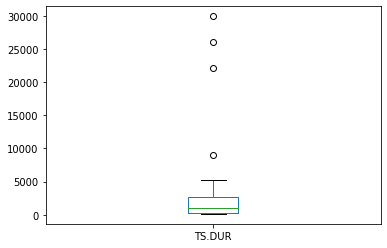

In [14]:
durcon['TS.DUR'].plot.box()

Look at the difference in scales, the during construction phase, is about 5 to 10 times greater.  
But lets apply some tests to formalize our interpretation.

In [15]:
stat, p = mannwhitneyu(precon['TS.PRE'],durcon['TS.DUR'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=221.000, p-value at rejection =0.042
Probably different distributions


In [16]:
results = stats.ttest_ind(precon['TS.PRE'], durcon['TS.DUR'])
print('statistic=%.3f, p-value at rejection =%.3f ' % (results[0], results[1]))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=-1.750, p-value at rejection =0.086 
Probably different distributions


Both these tests indicate that the data derive from distirbutions with different measures of central tendency (means). Lets now ask the question about normality, we will apply a test called `normaltest`.  This function tests a null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.  We will likely get a warning because our sample size is pretty small.

#### References

D’Agostino, R. B. (1971), “An omnibus test of normality for moderate and large sample size”, Biometrika, 58, 341-348

D’Agostino, R. and Pearson, E. S. (1973), “Tests for departure from normality”, Biometrika, 60, 613-622


In [17]:
stat, p = stats.normaltest(precon['TS.PRE'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably normal distributed')
else:
    print('Probably Not-normal distributed')

statistic=32.081, p-value at rejection =0.000
Probably Not-normal distributed


/opt/conda/envs/python/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [18]:
stat, p = stats.normaltest(durcon['TS.DUR'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably normal distributed')
else:
    print('Probably Not-normal distributed')

statistic=41.701, p-value at rejection =0.000
Probably Not-normal distributed


Our next question is "Are the data homoscedastic?" which sort of requires us to look up the meaning of "homoscedastic." 
It refers to the variance of the two data samples, are the variances the same or not.  From the box plots we see some differences but here we are asking if the differences are statistically significant.

### Bartlett's Test (for homoscedastic)

A simple (to implement) test is Bartlett's Pear test. 
Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances (https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm). 
For samples from significantly non-normal populations, Levene’s test `levene`_ is more robust (https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm). 

Here we will try both, bearing in mind that the Shirley and Levene test is more preferred for Happy Days distributed samples.

In [19]:
stat, p = stats.bartlett(precon['TS.PRE'],durcon['TS.DUR'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably homoscedastic')
else:
    print('Probably heteroscedastic')

statistic=74.447, p-value at rejection =0.000
Probably heteroscedastic


In [20]:
stat, p = stats.levene(precon['TS.PRE'],durcon['TS.DUR'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably homoscedastic')
else:
    print('Probably heteroscedastic')

statistic=3.254, p-value at rejection =0.077
Probably homoscedastic


While these produce contradictory results, recall we already know the samples depart from normality so we would favor the Levene test.
At this point we have answered most of the questions, except for the solids management question - which is left as an exercise. To summarize:
 
   Are the data approximately normal?  `No` based on `stats.normaltest()`
   
   Are the data homoscedastic? `No` based on `stats.levene(,)`
   
   Do the two construction phases represent approximately the same rainfall conditions? `Yes` based on `mannwhitneyu()` or T-tests
  
### Exercise Set 1:
1) Do the total suspended solids measures exhibit the same behavior as the total solids in the example. (Do the analysis!)

2) Assuming the observations are upstream of any water quality control feature, what amount of solids load needs to be captured to preserve pre-construction loading to the environment?

<hr>

# Example 2: Treaty Terms for the Colorado River 

## Background

The Colorado river originates in the Rocky mountains and has contributing tributaries
and/or flows through the states of Wyoming, Colorado, Utah, Nevada, Arizona,
and California. 
Prior to dams the river used to actually run to the ocean and at one
time in history actually had commerce by river boats. 
In the late 1800’s and early 1900’s the river and its tributaries were dammed and diverted. 
Around the 1920’sa legal document called the Colorado River Compact was developed. 
A Compact is similar to a treaty, except the parties to the treaty are states (essentially the individual states have entered into the treaty with the United States and Mexico). 
The Colorado River Compact divides the Colorado River into Upper and Lower Basins with the division being at Lee Ferry on the Colorado River one mile below the Paria River in Arizona.
The Lower Basin states are Arizona, California, and Nevada, with small portions of New Mexico and Utah that are tributary to the Colorado River below Lee Ferry. The Upper Basin states are Colorado, New Mexico, Utah, and Wyoming, with a small portion of Arizona tributary to the Colorado River above Lee Ferry.

Article III of the Compact apportions the waters of the Colorado River to the Upper
and Lower Basins as follows:
The Compact apportions the right to exclusive beneficial consumptive use of 7.5
million acre-feet of water per year from the ”Colorado River System” in perpetuity
to the Upper Basin and the Lower Basin.
The Compact allows an additional 1.0 million acre-feet per year of increased beneficial
consumptive use to the Lower Basin.
It provides water for Mexico pursuant to treaty. Water must first come from any
surplus over the waters allocated to the states in Article III(a) and (b). If that
surplus is insufficient, then the burden of that deficiency shall be shared equally by
the Upper and Lower Basins.
The Compact provides that the Upper Basin states will not cause the flow of the
river at Lee Ferry, Arizona to be depleted below an aggregate of 75 million acrefeet
for any period of ten consecutive years beginning with the ratification of the
Compact.
It provides that the Upper Basin states will not withhold water and the states of the
Lower Basin shall not require delivery of water which cannot reasonably be applied
to domestic and agricultural uses.

## Problem Statement

The file named COLORADO.TXT contains annual natural flows volumes in the upper
Colorado river basin from 1906 to present. These flows are historical reconstruction
at approximately the same location as the current USGS gage 09380000. The
location is approximately above (upstream of) Lee Ferry, hence the data represent
the flows out of the upper basin.
The data are in two columns, the first is the water year, the second column is
cumulative discharge for the year in units of acre-feet.

    YEAR ANNUAL.VOLUME
    1906 18550021
    1907 21201694
    1908 12218817
    1909 22356301
    1910 14650616
    ...
Prepare an analysis of the data to support or refute the provisions of the Compact.
You can assume that the data from 1906 to 1927 (the original Compact was ratified
in 1922, many additional Compacts have been signed since all trying to reapportion
water in the river basin witout violating the original agreement) were available to the
authors of the Colorado River Compact, analyze this period of data and decide if the
allocations to the lower basin are realistic (8.5 million acre-feet-per year) assuming
the upper basin allocation is removed. Consumptive use means that the water may
not return to the basin. The data are ’natural’ flows and the upper basin allocations
are not removed in the data. Also, as in the previous problem, these data are timeseries
and serial correlation is anticipated.

Estimate the probability based on the the 20-year period that the lower basin allocation
will not be met if upper basin allocation is satisfied. Estimate the probability
that the allocation will not be met using the entire data set if the upper basin allocation
is satisfied.

Next assume that lower basin is satisfied first (this is the historical result of the
original and subsequent treaties). Estimate the probability that the upper basin
allocation will not be met. Determine an upper basin allocation that will be met
95% of the time. Again use the 20 year initial record, then the entire record.

After these exploratory analyses decide if the basin allocations reasonable in the
context of the flows that actually occured after the Compact was in effect? That
is was the initial 20 year period sufficiently different from the later data that the
Compact authors made decisions based on unusually high or low flows?

In [21]:
remote_webroot="http://atomickitty.ddns.net/documents/JupyterOrion/MyJupyterNotebooks/41A-HypothesisTests/"  # set the webroot
remote_url=remote_webroot+"colorado.txt"
rget = requests.get(remote_url, allow_redirects=True)  # get the remote resource, follow imbedded links
open('colorado.txt','wb').write(rget.content) # extract from the remote the contents, assign to a local file same name

1571

,YEAR,ANNUAL.VOLUME
count,98.000000,9.800000e+01
mean,1954.500000,1.508335e+07
std,28.434134,4.445773e+06
min,1906.000000,5.407262e+06
25%,1930.250000,1.143192e+07
50%,1954.500000,1.489496e+07
75%,1978.750000,1.831991e+07
max,2003.000000,2.539764e+07


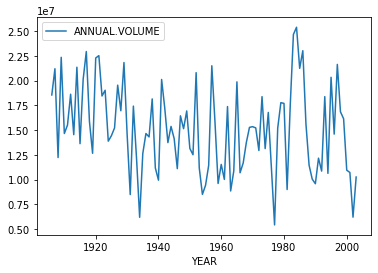

In [22]:
colorado_df = pd.read_table("colorado.txt") # Read the file as a table assign to a dataframe 
colorado_df.plot.line(x='YEAR', y='ANNUAL.VOLUME')
colorado_df.describe()

We can kind of use the description to answer our questions.  
Estimate the probability based on the the 20-year period that the lower basin allocation will not be met if upper basin allocation is satisfied

First filter the data

,YEAR,ANNUAL.VOLUME
count,22.000000,2.200000e+01
mean,1916.500000,1.770751e+07
std,6.493587,3.542334e+06
min,1906.000000,1.221882e+07
25%,1911.250000,1.456493e+07
50%,1916.500000,1.849861e+07
75%,1921.750000,2.093699e+07
max,1927.000000,2.294280e+07


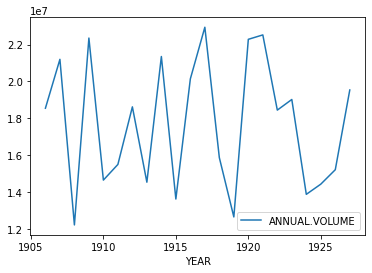

In [23]:
junkdf = colorado_df[colorado_df['YEAR'] <= 1927] # screen by year
junkdf.plot.line(x='YEAR', y='ANNUAL.VOLUME') # plot the first 22 years
junkdf.describe()

Then observe that the minimum is 12 million, so the upper basin's 7.5 million is satisfied all 22 years (yay for the upstreamers!)
If the downstreamers get their allocation the total in the river needs to be 15 million, so the question is what fraction of observations is less than 15 million, that fraction is an estimate of the probability downstreamers won't get their water.

In [24]:
result1 = junkdf.count()
result2 = junkdf[junkdf['ANNUAL.VOLUME'] < 15.0E6].count()
print ('Probability Downstreamers Wont Get their Agua =%.3f' % (result2[0]/result1[0]))

Probability Downstreamers Wont Get their Agua =0.318


The fraction is about 1/3; so 33% of the time, downstreamers won't get their water!

Estimate the probability that the allocation will not be met using the entire data set if the upper basin allocation is satisfied.
Here we use the same logic and scripts but dont need the date filter

In [25]:
result1 = colorado_df.count()
result2 = colorado_df[colorado_df['ANNUAL.VOLUME'] < 15.0E6].count()
print ("Probability Downstreamers Wont Get their Agua =%.3f " % (result2[0]/result1[0]))

Probability Downstreamers Wont Get their Agua =0.500 


So the downstreamers wont get water 1/2 the time.

Next assume that lower basin is satisfied first (this is the historical result of the original and subsequent treaties). 
Determine an upper basin allocation that will be met 95% of the time. 

Again use the 22 year initial record, then the entire record.

In [26]:
result1 = junkdf.count()
result2 = junkdf[junkdf['ANNUAL.VOLUME'] > 12.5e6].count()
print ('Probability Uptreamers Will Get their Agua based on 22 years =%.3f' % (result2[0]/result1[0]))
print ('Allocation Upstream =%.3f' % (12.5e6 - 7.5e6))
result1 = colorado_df.count()
result2 = colorado_df[colorado_df['ANNUAL.VOLUME'] > 8.5e6].count()
print ('Probability Uptreamers Will Get their Agua based on 98 years =%.3f' % (result2[0]/result1[0]))
print ('Allocation Upstream =%.3f' % (8.5e6 - 7.5e6))

Probability Uptreamers Will Get their Agua based on 22 years =0.955
Allocation Upstream =5000000.000
Probability Uptreamers Will Get their Agua based on 98 years =0.949
Allocation Upstream =1000000.000


So based on 22 years of record, 5 million acre feet allocation would be satisfied 95% of the time.
Using the entire record, only 1 million acre feet was available for the upstream - interestingly that same extra 1 million already available to the downstreamers.

Not a favorable contract for Upstreamers and Mexico, the big error was the choice of absolute volumes; flow fractions would have made more sense and still kept lawyers busy.  

One observation in https://en.wikipedia.org/wiki/Cadillac_Desert notes that the base years were unusually wet - we can assess that claim using our hypothesis testing tools.  First we will check for normality

In [27]:
newjunkdf = colorado_df[colorado_df['YEAR'] > 1927] # screen by year
stat, p = stats.normaltest(junkdf['ANNUAL.VOLUME'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably normal distributed')
else:
    print('Probably Not-normal distributed')
    stat, p = stats.normaltest(newjunkdf['ANNUAL.VOLUME'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably normal distributed')
else:
    print('Probably Not-normal distributed')

statistic=7.070, p-value at rejection =0.029
Probably Not-normal distributed
statistic=2.071, p-value at rejection =0.355
Probably normal distributed


So the first portion of the data seem non-normal, the later quite normal, likely a consequence of moderate sample size (80-ish) and a bounded physical process (infinite discharge makes no sense, less then zero also undefined).  Lets ask Shirely and Laverne what they think about variance.

In [28]:
stat, p = stats.levene(junkdf['ANNUAL.VOLUME'],newjunkdf['ANNUAL.VOLUME'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably homoscedastic')
else:
    print('Probably heteroscedastic')

statistic=0.907, p-value at rejection =0.343
Probably homoscedastic


So we have non-static variance, from the plots it looks to be increasing with respect to time, a quick check

In [29]:
oldvar = (junkdf['ANNUAL.VOLUME'].std())**2
newvar = (newjunkdf['ANNUAL.VOLUME'].std())**2
print('Variance first 22 years =%.3e' % oldvar)
print('Variance last 86 years =%.3e' % newvar)

Variance first 22 years =1.255e+13
Variance last 86 years =1.944e+13


So the variance increased in the more reçent years, lets check means

In [30]:
oldmean = (junkdf['ANNUAL.VOLUME'].mean())
newmean = (newjunkdf['ANNUAL.VOLUME'].mean())
print('Mean first 22 years =%.3e' % oldmean)
print('Mean last 86 years =%.3e' % newmean)

Mean first 22 years =1.771e+07
Mean last 86 years =1.432e+07


So there is evidence that the early years were wetter, by about 3 million acre feet.  Lets examine if the difference is significant using our hypothesis testing tools.

In [31]:
stat, p = mannwhitneyu(junkdf['ANNUAL.VOLUME'],newjunkdf['ANNUAL.VOLUME'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

statistic=453.000, p-value at rejection =0.001
Probably different distributions


Based on the Mann-Whitney test the statement in Cadillac Desert is defendible, the early years are indeed different (wetter) with a small p-value, so its  likely the difference is not random.

### Exercise
If you were to rewrite the Compact provisions today, assuming that the original
intent was to divide the water between upper and lower basin in a 46% 54% split,
what annual allocations would you recomend as ’firm’ water at 90% reliability?

<hr>

# Example 3 Is a stinky bayou explained by water quality?

## Background

Country Club Bayou, formerly Slaughterhouse Ditch, is located in southeast Houston.
The bayou drains from east to west connecting to Brays Bayou. The upper portion of the
bayou is conveyed in a concrete channel that was initially placed in the early 1900’s. The
lower portion of the bayou from the Hughes Street railroad bridge to the confluence with
Braes Bayou is open, unlined channel.

Pollution of the bayou has been problematic for at least a dozen years. Currently
suspected high nutrient loading somewhere in the covered portion of the bayou
contributes to observed low dissolved oxygen values, a septic `odor`, and septic (black)
color. The out-fall from the covered portion of the bayou to the open portion is just
upstream of the Hughes Street Bridge. Samples collected at the bridge by the City of
Houston Health Department confirm these historical observations.

At times the water at the out-fall just upstream of the Hughes Street Bridge has not meet
state water quality standards for unclassified waters. Unclassified waters are waters
which are not specifically listed in Appendices A or D of §307.10 of Title:30, Part 1,
Chapter 307 of the Texas Administrative Code. 

The table lists some of the relevant standards. 
<table>
<tr><td>Parameter</td><td> Value</td><td> Remarks</td></tr>
    <tr><td>Dissolved Oxygen</td><td> 2.0 mg/L - 24 hr. average        </td><td>  </td></tr>
    <tr><td>                </td><td> 1.5 mg/L - absolute minimum      </td><td>  </td></tr>
    <tr><td>                </td><td> 3.0 mg/L - proposed (circa 1998) </td><td>  </td></tr>
    <tr><td>         Sulfate</td><td>  65 mg/L - proposed (circa 1998) </td><td>  </td></tr>
    <tr><td>              pH</td><td>  6.5-9.0 - proposed (circa 1998) </td><td>  </td></tr>
    <tr><td>  Fecal Coliform</td><td>                    200 cfu/100mL </td><td> Contact recreation </td></tr>
    <tr><td>                </td><td>                   2000 cfu/100mL </td><td> Non-contact recreation </td></tr>
    <tr><td>     Temperature</td><td> 4oF above ambient</td><td> Fall, Winter, Spring</td></tr>
    <tr><td>                </td><td> 1.5oF above ambient</td><td> Summer</td></tr>
    </table>
These values are proposed for Segment 1014 (Buffalo Bayou above tidal) for contact
recreation and limited aquatic life use.

See: (http://www.tnrcc.state.tx.us/water/quality/standards/revisions.html)

The figure below is a map of the area with storm and sanitary sewer systems drawn onto the map (the study pre-dates affordable GIS)

![figure 1](CCBayoyMap.png)

The current land-use in the area ranges includes residential, light-industrial, and several
manufacturing facilities. The covered portion of the storm sewer system is owned
by the City of Houston, while the open portion appears to be privately owned except for
the portion through Wortham Park (COH). There are no known discharge permits issued
by any authority for discharge into Country Club Bayou.

The figure below shows sample locations were water quality samples were collected

![figure 1](SampleLocations.png)

For this example, the data from the Hughes Street location are examined.  
The data are stored in the file named HUGHES_STREET.txt and look like:

    MM	DD	YY	pH	T_degC	DO_ppm	NH3_ppm	Odor
    11	1	1999	6.63	22.5	4.54	0.63	0
    5	28	1998	7.3	23.2	1.7	0.54	0
    6	3	1998	7.2	24.1	1.2	0.31	0
    6	8	1998	7.1	24.8	1	3.96	0
    6	15	1998	7.2	25	2.9	0.57	0
    6	26	1998	7.3	27.2	3.1	1.29	0
    6	29	1998	7.7	26.2	7.9	0.28	0
    7	8	1998	6.5	26.2	0.28	0.21	0
    7	20	1998	6.5	28	8.1	0.32	0
    ...
    7	15	1999	7.08	27.5	3.19	0.52	0
    5	12	1998	7	21.6	1.41	0.66	1
    5	21	1998	7.2	23.9	1.2	1.23	1
    5	27	1998	6.9	23.6	1.1	0.36	1
    6	11	1998	7	24.9	1.7	2.5	1
    ...

## Problem Statement

The simple question for this example: Are the water quality measures different when the field notes report the classification variable "Odor" as "1"?

As before, first lets get the data

In [32]:
remote_webroot="http://atomickitty.ddns.net/documents/JupyterOrion/MyJupyterNotebooks/41A-HypothesisTests/"  # set the webroot
remote_url=remote_webroot+"HUGHES_STREET.txt"
rget = requests.get(remote_url, allow_redirects=True)  # get the remote resource, follow imbedded links
open('HUGHES_STREET.txt','wb').write(rget.content) # extract from the remote the contents, assign to a local file same name
ccbayou = pd.read_table("HUGHES_STREET.txt") # Read the file as a table assign to a dataframe 
ccbayou.describe()

,MM,DD,YY,pH,T_degC,DO_ppm,NH3_ppm,Odor
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,6.179487,15.782051,1998.487179,7.181205,21.796154,2.993564,0.733846,0.538462
std,3.301883,8.851807,0.503071,0.432250,3.859898,2.105167,0.606108,0.501745
min,1.000000,1.000000,1998.000000,6.263000,10.800000,0.260000,0.000000,0.000000
25%,3.000000,8.250000,1998.000000,6.925750,18.425000,1.355000,0.322500,0.000000
50%,6.000000,15.000000,1998.000000,7.122000,22.550000,2.725000,0.620000,1.000000
75%,9.000000,23.000000,1999.000000,7.369750,25.000000,3.635000,0.977500,1.000000
max,12.000000,30.000000,1999.000000,8.735000,28.000000,9.240000,3.960000,1.000000


Lets look at some plots, after filtering the dataframe

<AxesSubplot:>

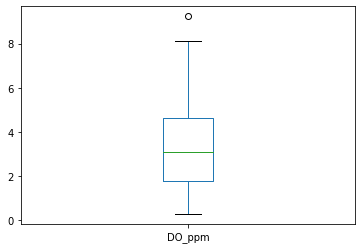

In [33]:
yummydf = ccbayou[ccbayou['Odor'] == 0]
stinkydf = ccbayou[ccbayou['Odor'] == 1]
yummydf['DO_ppm'].plot.box()

<AxesSubplot:>

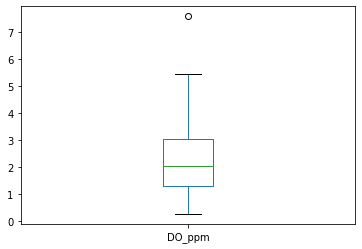

In [34]:
stinkydf['DO_ppm'].plot.box() 

Not much from a plot, in general if we look at descriptions we will observe lower DO and higher NH3 for the cases where odor is reported.  These data are good candidate for hypothesis testing, first check for normality (if yes then we will T-test)

In [35]:
print('Testing on DO_ppm')
stat, p = stats.normaltest(stinkydf['DO_ppm'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably normal distributed')
else:
    print('Probably Not-normal distributed')
    stat, p = stats.normaltest(yummydf['DO_ppm'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably normal distributed')
else:
    print('Probably Not-normal distributed')
    
print('Testing on NH3_ppm')
stat, p = stats.normaltest(stinkydf['NH3_ppm'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably normal distributed')
else:
    print('Probably Not-normal distributed')
    stat, p = stats.normaltest(yummydf['NH3_ppm'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably normal distributed')
else:
    print('Probably Not-normal distributed')

Testing on DO_ppm
statistic=14.361, p-value at rejection =0.001
Probably Not-normal distributed
statistic=4.447, p-value at rejection =0.108
Probably normal distributed
Testing on NH3_ppm
statistic=8.570, p-value at rejection =0.014
Probably Not-normal distributed
statistic=59.546, p-value at rejection =0.000
Probably Not-normal distributed


So pretty much non-normal, hence we will rely on Mann-Whitney

In [36]:
print('Testing on DO_ppm')
stat, p = mannwhitneyu(yummydf['DO_ppm'],stinkydf['DO_ppm'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')
print('Testing on NH3_ppm')
stat, p = mannwhitneyu(yummydf['NH3_ppm'],stinkydf['NH3_ppm'])
print('statistic=%.3f, p-value at rejection =%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

Testing on DO_ppm
statistic=493.000, p-value at rejection =0.004
Probably different distributions
Testing on NH3_ppm
statistic=534.500, p-value at rejection =0.013
Probably different distributions


These tests suggest that DO and NH3 play a role in the observation of Odor

In [37]:
print('Average DO no-odor =%.3f' % yummydf['DO_ppm'].mean())
print('Average DO odor =%.3f' % stinkydf['DO_ppm'].mean())
print('Average NH3 no-odor =%.3f' % yummydf['NH3_ppm'].mean())
print('Average NH3 odor =%.3f' % stinkydf['NH3_ppm'].mean())

Average DO no-odor =3.709
Average DO odor =2.380
Average NH3 no-odor =0.624
Average NH3 odor =0.828


## Exercise

Are these observations homoscedastic?

## References
Cleveland, T.G., Davis, J.L., Zhu, H., Bougai, D., Linares, M. 2000. 
``Investigation and Demonstration of Intervention Strategies to Improve Water Quality on Country Club Bayou.'' Final Report to Houston Wastewater Program, Texas Natural Resources Conservation Commission, City of Houston, and the Environmental Institute of Houston 

http://atomickitty.ddns.net/documents/resumes/MyWebPapers/project_reports/ccbayou_report/

In [38]:
sortedDOyum = yummydf.sort_values(by=['DO_ppm'])
sortedDOstk = stinkydf.sort_values(by=['DO_ppm'])

In [39]:
sortedDOyum.head()

,MM,DD,YY,pH,T_degC,DO_ppm,NH3_ppm,Odor
7,7,8,1998,6.500,26.2,0.280,0.21,0
3,6,8,1998,7.100,24.8,1.000,3.96,0
21,11,4,1998,7.370,21.0,1.118,0.32,0
20,10,28,1998,7.370,22.7,1.140,1.06,0
33,6,22,1999,6.843,26.2,1.160,0.39,0


In [40]:
sDOy = sortedDOyum['DO_ppm']

In [41]:
sDOy.describe()

count    36.000000
mean      3.708833
std       2.442435
min       0.280000
25%       1.760000
50%       3.100000
75%       4.620000
max       9.240000
Name: DO_ppm, dtype: float64

In [45]:
relfreq = [(x+1)/36 for x in range(35) ]

In [48]:
sDOy['DO_ppm'].plot.line(x=relfreq,y='DO_ppm')

KeyError: 'DO_ppm'